# This notebook was created to 1. collect (SNP & INDEL) variants in *mmpL5*, *mmpS5* and *mmpR*, 2. detect instances of co-occurence of LoF variants in *mmpL5-mmpS5* and the *mmpR* and 3. analyze/date mutations on the lineage 4.2.1.1.1.1.2 phylogeny

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio import Phylo

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy
from collections import Counter

# *mmpL5* - *mmpS5* - *mmpR*

mmpL5: 775,586 - 778,480

mmpS5: 778,477 - 778,905

mmpR: 778,990 - 779,487

H37Rv region: 775,586 - 779,487

In [4]:
H37Rv_region_start = 775586
H37Rv_region_end = 779487
regulator_id = 'Rv0678'
regulon_id_A = 'Rv0676c'
regulon_id_B = 'Rv0677c'
gene_symbol = 'mmpL5-mmpS5-mmpR'

### *Function* to convert lineage-calls to new/simpler lineage call scheme

In [5]:
def convert_lineage_calls(isolate_annotation_DF):

    lineage_hierarchincal_to_lineage_map_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/lineage_hierachical_to_lineage_map.csv')
    lineage_hierarchincal_to_lineage_map_series = pd.Series(list(lineage_hierarchincal_to_lineage_map_df.loc[:, 'lineage']), index = lineage_hierarchincal_to_lineage_map_df.lineage_hierarchical)

    lineage_call_update_list = []

    for hierarchical_lineage_call in isolate_annotation_DF.lineage_call:

        # if lineage call has an updated shorter call
        if hierarchical_lineage_call in lineage_hierarchincal_to_lineage_map_series.index:
            lineage_call_update_list.append(lineage_hierarchincal_to_lineage_map_series[hierarchical_lineage_call])

        # if lineage call doesn't have an updated shorter call
        else:
            lineage_call_update_list.append(hierarchical_lineage_call)

    # replace the hierarchical calls with the shorter ones
    isolate_annotation_DF.loc[:,'lineage_call'] = lineage_call_update_list
    
    return isolate_annotation_DF

# [1] INDELs

## [1.1] Load INDEL genotype matrix and Annotation Files

### 31,428 isolates

In [6]:
#load isolate annotation file (columns of Genotype Matrix)
INDEL_isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')
INDEL_isolate_annotation_DF = INDEL_isolate_annotation_DF.loc[:, ['isolate_ID','lineage_call']] #drop columns
INDEL_isolate_annotation_DF = convert_lineage_calls(INDEL_isolate_annotation_DF)

#load INDEL annotation file (rows of Genotype Matrix) with gene annotation information
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_functional_annotation.pkl')
INDEL_annotation_DF.reset_index(inplace = True, drop = False)

#load Genotypes Matrix
INDEL_genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_matrix.npy')

In [7]:
INDEL_isolate_annotation_DF.head()

,isolate_ID,lineage_call
0,SAMN13051687,2.2.1.1.1.i3
1,SAMN09100245,4.3.i4.1
2,SAMN08732238,2.2.1.1.1
3,SAMN07658260,3.1.1
4,SAMN03648003,2.2.1.1.1


In [8]:
np.shape(INDEL_isolate_annotation_DF)

(31428, 2)

In [9]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,Essential,dnaA,Rv0001,313,del,inframe,105
1,TC_1549_T,1549,TC,T,None,None,Rv0001_Rv0002,None,del,frameshift,None
2,T_1552_TAA,1552,T,TAA,None,None,Rv0001_Rv0002,None,ins,frameshift,None
3,TAA_1552_T,1552,TAA,T,None,None,Rv0001_Rv0002,None,del,frameshift,None
4,T_1552_TA,1552,T,TA,None,None,Rv0001_Rv0002,None,ins,frameshift,None


In [10]:
np.shape(INDEL_annotation_DF)

(50260, 11)

In [11]:
INDEL_genotypes_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [12]:
np.shape(INDEL_genotypes_array)

(50260, 31428)

### additional 12 eis C-14T mutants with AG MICs

In [13]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF_extra_strains = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes/Genotypes_Filtered/genotypes_isolate_annotation.pkl')
isolate_annotation_DF_extra_strains = isolate_annotation_DF_extra_strains.loc[:, ['isolate_ID','lineage_call']]
isolate_annotation_DF_extra_strains = convert_lineage_calls(isolate_annotation_DF_extra_strains)

#load Genotypes Matrix
genotypes_array_extra_strains =  np.load('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes_indels/Genotypes_Filtered/genotypes_matrix.npy')

In [14]:
isolate_annotation_DF_extra_strains.head()

,isolate_ID,lineage_call
0,168-19,2.2.1.1.1
1,622-19,2.2.1.1.1.i3
2,655-19,4.3.i3.1
3,IT1070,2.2.1.1.1.i3
4,IT123,2.2.1.1.1


In [15]:
genotypes_array_extra_strains

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 9, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [16]:
np.shape(genotypes_array_extra_strains)

(50260, 12)

### Merge *isolate annotation files* and *genotypes matrices* together

In [17]:
# merge isolate annotation dataframes
INDEL_isolate_annotation_DF = INDEL_isolate_annotation_DF.append(isolate_annotation_DF_extra_strains)
INDEL_isolate_annotation_DF.reset_index(inplace = True, drop = True)

In [18]:
np.shape(INDEL_isolate_annotation_DF)

(31440, 2)

In [19]:
# merge genotypes matrices
INDEL_genotypes_array = np.hstack((INDEL_genotypes_array, genotypes_array_extra_strains))

In [20]:
np.shape(INDEL_genotypes_array)

(50260, 31440)

## [1.2] Subset to targeted chomosomal region

In [21]:
# keep only indels that occur within chromosomal region
indels_in_targeted_region = list(INDEL_annotation_DF[(INDEL_annotation_DF.pos >= H37Rv_region_start) & (INDEL_annotation_DF.pos <= H37Rv_region_end)].key)

# construct boolean filter
indels_to_keep_filter = [indel_i in indels_in_targeted_region for indel_i in INDEL_annotation_DF.key]

# filter Genotypes Matrix
INDEL_genotypes_array = INDEL_genotypes_array[indels_to_keep_filter , :]

# filter INDEL annotation file
INDEL_annotation_DF = INDEL_annotation_DF[indels_to_keep_filter]
INDEL_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered INDEL annotation DF (so new index matches indexing of genotypes matrix rows)

In [22]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
0,C_775616_CG,775616,C,CG,Non-Essential,mmpL5,Rv0676c,2865,ins,frameshift,955
1,CGGA_775716_C,775716,CGGA,C,Non-Essential,mmpL5,Rv0676c,2765,del,inframe,922
2,GGT_775727_G,775727,GGT,G,Non-Essential,mmpL5,Rv0676c,2754,del,frameshift,918
3,TG_775753_T,775753,TG,T,Non-Essential,mmpL5,Rv0676c,2728,del,frameshift,910
4,GT_775758_G,775758,GT,G,Non-Essential,mmpL5,Rv0676c,2723,del,frameshift,908


In [23]:
np.shape(INDEL_annotation_DF)

(83, 11)

In [24]:
INDEL_genotypes_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [25]:
np.shape(INDEL_genotypes_array)

(83, 31440)

# [2] SNPs

### 31,428 isolates

## [2.1] Load SNP genotype matrix and Annotation Files

In [26]:
#load isolate annotation file (columns of Genotype Matrix)
SNP_isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')
SNP_isolate_annotation_DF = SNP_isolate_annotation_DF.loc[:, ['isolate_ID','lineage_call']] #drop columns
SNP_isolate_annotation_DF = convert_lineage_calls(SNP_isolate_annotation_DF)

#load INDEL annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')
SNP_annotation_DF = SNP_annotation_DF.loc[:, ['pos','ref','alt']] # drop columns
SNP_annotation_DF.reset_index(inplace = True, drop = False)

#load Genotypes Matrix
SNP_genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy')

In [27]:
SNP_isolate_annotation_DF.head()

,isolate_ID,lineage_call
0,SAMEA3558733,4.3.i4.2
1,SAMN03648641,4.4.1.1
2,SAMN03647419,3.1.1.i1
3,SAMEA3671418,4.3.i2
4,SAMN07659096,1.1.3


In [28]:
np.shape(SNP_isolate_annotation_DF)

(31428, 2)

In [29]:
SNP_annotation_DF.head()

,index,pos,ref,alt
0,0,48,C,[T]
1,1,64,G,[C]
2,2,67,G,"[A, T]"
3,3,69,C,[T]
4,4,71,C,[T]


In [30]:
np.shape(SNP_annotation_DF)

(782565, 4)

In [31]:
SNP_genotypes_array

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 9, 9, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1]], dtype=int8)

In [32]:
np.shape(SNP_genotypes_array)

(782565, 31428)

### additional 12 eis C-14T mutants with AG MICs

In [33]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF_extra_strains = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes/Genotypes_Filtered/genotypes_isolate_annotation.pkl')
isolate_annotation_DF_extra_strains = isolate_annotation_DF_extra_strains.loc[:, ['isolate_ID','lineage_call']]
isolate_annotation_DF_extra_strains = convert_lineage_calls(isolate_annotation_DF_extra_strains)

#load Genotypes Matrix
genotypes_array_extra_strains =  np.load('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes/Genotypes_Filtered/genotypes_matrix.npy')

In [34]:
isolate_annotation_DF_extra_strains.head()

,isolate_ID,lineage_call
0,168-19,2.2.1.1.1
1,622-19,2.2.1.1.1.i3
2,655-19,4.3.i3.1
3,IT1070,2.2.1.1.1.i3
4,IT123,2.2.1.1.1


In [35]:
genotypes_array_extra_strains

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

In [36]:
np.shape(genotypes_array_extra_strains)

(782565, 12)

### Merge *isolate annotation files* and *genotypes matrices* together

In [37]:
# merge isolate annotation dataframes
SNP_isolate_annotation_DF = SNP_isolate_annotation_DF.append(isolate_annotation_DF_extra_strains)
SNP_isolate_annotation_DF.reset_index(inplace = True, drop = True)

In [38]:
np.shape(SNP_isolate_annotation_DF)

(31440, 2)

In [39]:
# merge genotypes matrices
SNP_genotypes_array = np.hstack((SNP_genotypes_array, genotypes_array_extra_strains))

In [40]:
np.shape(SNP_genotypes_array)

(782565, 31440)

## [2.2] Subset to targeted chomosomal region

In [41]:
# keep only SNPs that occur within chromosomal region
SNPs_in_targeted_region = list(SNP_annotation_DF[(SNP_annotation_DF.pos >= H37Rv_region_start) & (SNP_annotation_DF.pos <= H37Rv_region_end)].pos)

# construct boolean filter
SNPs_to_keep_filter = [SNP_i in SNPs_in_targeted_region for SNP_i in SNP_annotation_DF.pos]

# filter Genotypes Matrix
SNP_genotypes_array = SNP_genotypes_array[SNPs_to_keep_filter , :]

# filter SNP annotation file
SNP_annotation_DF = SNP_annotation_DF[SNPs_to_keep_filter]
SNP_annotation_DF.reset_index(drop = True , inplace = True) #re-index new filtered SNP annotation DF (so new index matches indexing of genotypes matrix rows)
SNP_annotation_DF.loc[:,'array_index'] = SNP_annotation_DF.index

In [42]:
SNP_annotation_DF.head()

,index,pos,ref,alt,array_index
0,153487,775588,A,[C],0
1,153488,775592,C,[T],1
2,153489,775597,C,[T],2
3,153490,775606,G,[T],3
4,153491,775607,T,[C],4


In [43]:
np.shape(SNP_annotation_DF)

(804, 5)

#### Re-format SNP annotation DataFrame so that each alternate allele is its own row

In [44]:
SNP_annotation_DF_mod = pd.DataFrame(columns = SNP_annotation_DF.columns)
new_SNP_index = 0
for SNP_i_row in SNP_annotation_DF.index:
    
    SNP_i_info = SNP_annotation_DF.loc[SNP_i_row, :]
    
    #iterate through alternate alleles, store a row for each one
    for SNP_i_alt_allele in SNP_i_info.alt:
        
        SNP_annotation_DF_mod.loc[new_SNP_index, :] = list(SNP_i_info.loc[['index','pos','ref']]) + [SNP_i_alt_allele] + list(SNP_i_info.loc[['array_index']])
        new_SNP_index += 1

SNP_annotation_DF = SNP_annotation_DF_mod
#create new column to merge func annotation on
SNP_annotation_DF.loc[:, 'key'] = [str(SNP_i_pos) + '_' + SNP_i_alt for SNP_i_pos, SNP_i_alt in zip(SNP_annotation_DF.pos, SNP_annotation_DF.alt)]

In [45]:
SNP_annotation_DF.head()

,index,pos,ref,alt,array_index,key
0,153487,775588,A,C,0,775588_C
1,153488,775592,C,T,1,775592_T
2,153489,775597,C,T,2,775597_T
3,153490,775606,G,T,3,775606_T
4,153491,775607,T,C,4,775607_C


In [46]:
np.shape(SNP_annotation_DF)

(864, 6)

#### Merge functional annotation data

In [47]:
SNP_func_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_functional_annotation.pkl')
SNP_func_annotation_DF.loc[:, 'key'] = SNP_func_annotation_DF.index

In [48]:
SNP_func_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change,key
48_T,48,C,T,Essential,dnaA,Rv0001,48,S,V16V,48_T
64_C,64,G,C,Essential,dnaA,Rv0001,64,N,G22R,64_C
67_A,67,G,A,Essential,dnaA,Rv0001,67,N,D23N,67_A
67_T,67,G,T,Essential,dnaA,Rv0001,67,N,D23Y,67_T
69_T,69,C,T,Essential,dnaA,Rv0001,69,S,D23D,69_T


In [49]:
SNP_annotation_DF = SNP_annotation_DF.merge(SNP_func_annotation_DF.loc[: , ['gene_category','gene_name','gene_id','gene_pos','SNP_type','AA_change','key']], how = 'left', on = 'key')
SNP_annotation_DF = SNP_annotation_DF.loc[:, ['key','pos','ref','alt','gene_category','gene_name','gene_id','gene_pos','SNP_type','AA_change','array_index']] #re-arrange columns
SNP_annotation_DF.rename(columns={'SNP_type':'mut_type', 'AA_change':'codon_pos'}, inplace = True) #change column names

In [50]:
SNP_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index
0,775588_C,775588,A,C,Non-Essential,mmpL5,Rv0676c,2893,N,*965G,0
1,775592_T,775592,C,T,Non-Essential,mmpL5,Rv0676c,2889,S,L963L,1
2,775597_T,775597,C,T,Non-Essential,mmpL5,Rv0676c,2884,N,A962T,2
3,775606_T,775606,G,T,Non-Essential,mmpL5,Rv0676c,2875,S,R959R,3
4,775607_C,775607,T,C,Non-Essential,mmpL5,Rv0676c,2874,S,A958A,4


In [51]:
np.shape(SNP_annotation_DF)

(864, 11)

In [52]:
SNP_genotypes_array

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

In [53]:
np.shape(SNP_genotypes_array)

(804, 31440)

# [3] Pull info for isolates with mutant alleles

## [3.1] Get genotypes for SNPs of interest

### *Function* to get the genotypes for a specifc SNP and get attributes for isolates that support SNP

In [54]:
def get_genotypes_for_SNP(SNP_i_pos, SNP_i_alt_allele):
    
    #get the number code that corresponds to the alt allele, 9 indicated bad quality call
    base_code_dict = {'A':0, 'C':1, 'G':2, 'T':3}
    SNP_i_alt_allele_code = base_code_dict[SNP_i_alt_allele]
    SNP_i_genotypes = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_i_pos].array_index.values[0] , :] 

    #count the number of isolates that support this SNP call
    num_isolates_SNP_i = np.sum(SNP_i_genotypes == SNP_i_alt_allele_code)

    #create a boolean filter and extract information for the isolates that support this call
    SNP_i_isolate_filter = SNP_i_genotypes == SNP_i_alt_allele_code
    isolate_annotation_SNP_i = SNP_isolate_annotation_DF[SNP_i_isolate_filter]

    #find number of sub-lineages that have SNP support in at least 1 isolate
    num_sublineages_with_SNP_i = len(set(list(isolate_annotation_SNP_i.lineage_call.values)))
    
    #get list of sublineages w/ at least 1 isolates that supports SNP call
    sublineages_with_SNP_count_dict = Counter(isolate_annotation_SNP_i.lineage_call.values)
    sublineages_with_SNP_list = []
    for sublineage_i in sublineages_with_SNP_count_dict.keys():

        sublineage_i_with_SNP = sublineage_i + '({0})'.format(str(sublineages_with_SNP_count_dict[sublineage_i]))
        sublineages_with_SNP_list.append(sublineage_i_with_SNP)

    sublineages_with_SNP = ' - '.join(sublineages_with_SNP_list)

    return [num_isolates_SNP_i , num_sublineages_with_SNP_i , sublineages_with_SNP]

In [55]:
SNP_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index
0,775588_C,775588,A,C,Non-Essential,mmpL5,Rv0676c,2893,N,*965G,0
1,775592_T,775592,C,T,Non-Essential,mmpL5,Rv0676c,2889,S,L963L,1
2,775597_T,775597,C,T,Non-Essential,mmpL5,Rv0676c,2884,N,A962T,2
3,775606_T,775606,G,T,Non-Essential,mmpL5,Rv0676c,2875,S,R959R,3
4,775607_C,775607,T,C,Non-Essential,mmpL5,Rv0676c,2874,S,A958A,4


In [56]:
np.shape(SNP_annotation_DF)

(864, 11)

In [57]:
num_isolates_with_SNP = []
num_sublineages_with_SNP = []
sublineages_with_SNP = []

for SNP_i_pos, SNP_i_alt_allele in zip(SNP_annotation_DF.pos, SNP_annotation_DF.alt):
    
    num_isolates_with_SNP_i , num_sublineages_with_SNP_i , sublineages_with_SNP_i = get_genotypes_for_SNP(SNP_i_pos, SNP_i_alt_allele)
    
    num_isolates_with_SNP.append(num_isolates_with_SNP_i)
    num_sublineages_with_SNP.append(num_sublineages_with_SNP_i)
    sublineages_with_SNP.append(sublineages_with_SNP_i)
    
SNP_annotation_DF.loc[: , 'num_isolates'] = num_isolates_with_SNP
SNP_annotation_DF.loc[: , 'num_sublineages'] = num_sublineages_with_SNP
SNP_annotation_DF.loc[: , 'sublineages'] = sublineages_with_SNP

#drop SNPs present in 0 isolates
SNP_annotation_DF = SNP_annotation_DF[SNP_annotation_DF.num_isolates > 0]
SNP_annotation_DF.reset_index(inplace = True, drop = True)

In [58]:
SNP_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
0,775588_C,775588,A,C,Non-Essential,mmpL5,Rv0676c,2893,N,*965G,0,1,1,1.2.2.1(1)
1,775592_T,775592,C,T,Non-Essential,mmpL5,Rv0676c,2889,S,L963L,1,20,1,2.2.1.1.1(20)
2,775597_T,775597,C,T,Non-Essential,mmpL5,Rv0676c,2884,N,A962T,2,1,1,1.2.1.1.1(1)
3,775606_T,775606,G,T,Non-Essential,mmpL5,Rv0676c,2875,S,R959R,3,1,1,4.5(1)
4,775607_C,775607,T,C,Non-Essential,mmpL5,Rv0676c,2874,S,A958A,4,3,1,4.5(3)


In [59]:
np.shape(SNP_annotation_DF)

(856, 14)

## [3.2] Get genotypes for indels of interest

### *Function* to get the genotypes for a specifc indel and get attributes for isolates that support indel

In [60]:
def get_genotypes_for_indel(indel_i_key):
    
    #0 supports Ref, 1 supports Alt, 9 indicated bad quality call
    indel_i_genotypes = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == indel_i_key].index[0] , :] 

    #count the number of isolates that support this indel call
    num_isolates_indel_i = np.sum(indel_i_genotypes == 1)

    #create a boolean filter and extract information for the isolates taht support this call
    indel_i_isolate_filter = indel_i_genotypes == 1
    isolate_annotation_indel_i = INDEL_isolate_annotation_DF[indel_i_isolate_filter]

    #find number of sub-lineages that have indel support in at least 1 isolate
    num_sublineages_with_indel_i = len(set(list(isolate_annotation_indel_i.lineage_call.values)))
    
    #get list of sublineages w/ at least 1 isolates that supports indel call
    sublineage_with_indel_count_dict = Counter(isolate_annotation_indel_i.lineage_call.values)
    sublineages_with_indel_list = []
    for sublineage_i in sublineage_with_indel_count_dict.keys():

        sublineage_i_with_indel = sublineage_i + '({0})'.format(str(sublineage_with_indel_count_dict[sublineage_i]))
        sublineages_with_indel_list.append(sublineage_i_with_indel)

    sublineages_with_indel = ' - '.join(sublineages_with_indel_list)
    
    return [num_isolates_indel_i , num_sublineages_with_indel_i , sublineages_with_indel]

In [61]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos
0,C_775616_CG,775616,C,CG,Non-Essential,mmpL5,Rv0676c,2865,ins,frameshift,955
1,CGGA_775716_C,775716,CGGA,C,Non-Essential,mmpL5,Rv0676c,2765,del,inframe,922
2,GGT_775727_G,775727,GGT,G,Non-Essential,mmpL5,Rv0676c,2754,del,frameshift,918
3,TG_775753_T,775753,TG,T,Non-Essential,mmpL5,Rv0676c,2728,del,frameshift,910
4,GT_775758_G,775758,GT,G,Non-Essential,mmpL5,Rv0676c,2723,del,frameshift,908


In [62]:
np.shape(INDEL_annotation_DF)

(83, 11)

In [63]:
num_isolates_with_indel = []
num_sublineages_with_indel = []
sublineages_with_indel = []

for indel_i_key in INDEL_annotation_DF.key:
    
    num_isolates_with_indel_i , num_sublineages_with_indel_i , sublineages_with_indel_i = get_genotypes_for_indel(indel_i_key)
    
    num_isolates_with_indel.append(num_isolates_with_indel_i)
    num_sublineages_with_indel.append(num_sublineages_with_indel_i)
    sublineages_with_indel.append(sublineages_with_indel_i)
    
INDEL_annotation_DF.loc[: , 'num_isolates'] = num_isolates_with_indel
INDEL_annotation_DF.loc[: , 'num_sublineages'] = num_sublineages_with_indel
INDEL_annotation_DF.loc[: , 'sublineages'] = sublineages_with_indel

#drop indels present in 0 isolates
INDEL_annotation_DF = INDEL_annotation_DF[INDEL_annotation_DF.num_isolates > 0]

In [64]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
0,C_775616_CG,775616,C,CG,Non-Essential,mmpL5,Rv0676c,2865,ins,frameshift,955,1,1,4.13(1)
1,CGGA_775716_C,775716,CGGA,C,Non-Essential,mmpL5,Rv0676c,2765,del,inframe,922,1,1,1.1.1.1(1)
2,GGT_775727_G,775727,GGT,G,Non-Essential,mmpL5,Rv0676c,2754,del,frameshift,918,3,1,2.2.1.1.1(3)
3,TG_775753_T,775753,TG,T,Non-Essential,mmpL5,Rv0676c,2728,del,frameshift,910,14,1,5(14)
5,C_775876_CG,775876,C,CG,Non-Essential,mmpL5,Rv0676c,2605,ins,frameshift,869,2,1,1.1.1.1(2)


In [65]:
np.shape(INDEL_annotation_DF)

(80, 14)

# [4] Check co-occurrence between *regulator* SNPs/INDELs & *regulon* SNPs/INDELs

### SNPs in regulator

We're going to include SNPs in a gene that either 

- cause a **premature STOP codon** (nonsense mutation)
- **synonymous mutations at the first codon that abolish the start codon** (i.e. eis, whiB7 and mmpR which start with a **valine** as this is not possible with ahpC, mmpS5 or mmpL5, which start with a **methionine**)
- **non-synonymous mutations at the first codon that abolish the start codon** (i.e. that change the start to an AA other than **valine** and **methionine**)

In [66]:
regulator_SNPs_DF = SNP_annotation_DF[SNP_annotation_DF.gene_id == regulator_id]

In [67]:
regulator_SNPs_DF[[(AA_change[-1]=='*') | ((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulator_SNPs_DF.codon_pos]]

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
722,778992_A,778992,G,A,Non-Essential,Rv0678,Rv0678,3,S,V1V,678,1,1,1.2.2.1(1)
733,779026_T,779026,G,T,Non-Essential,Rv0678,Rv0678,37,N,E13*,688,1,1,4.5(1)
757,779115_A,779115,G,A,Non-Essential,Rv0678,Rv0678,126,N,W42*,712,1,1,2.2.2(1)
849,779455_T,779455,C,T,Non-Essential,Rv0678,Rv0678,466,N,R156*,797,1,1,5(1)


In [68]:
regulator_SNPs_DF = regulator_SNPs_DF[[(AA_change[-1]=='*') | ((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulator_SNPs_DF.codon_pos]]

In [69]:
regulator_SNPs_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
722,778992_A,778992,G,A,Non-Essential,Rv0678,Rv0678,3,S,V1V,678,1,1,1.2.2.1(1)
733,779026_T,779026,G,T,Non-Essential,Rv0678,Rv0678,37,N,E13*,688,1,1,4.5(1)
757,779115_A,779115,G,A,Non-Essential,Rv0678,Rv0678,126,N,W42*,712,1,1,2.2.2(1)
849,779455_T,779455,C,T,Non-Essential,Rv0678,Rv0678,466,N,R156*,797,1,1,5(1)


In [70]:
np.shape(regulator_SNPs_DF)

(4, 14)

Save SNPs that occur in the first codon seperately

In [71]:
regulator_SNPs_DF[[((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulator_SNPs_DF.codon_pos]].to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/START_codon_SNVs/mmpR_START_codon_SNVs.xlsx')

### INDELs in regulator

#### keep only *frameshift* indels for gene body

In [72]:
INDEL_annotation_DF[(INDEL_annotation_DF.gene_id == regulator_id) & (INDEL_annotation_DF.INDEL_type == 'frameshift')].head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
60,CGG_779004_C,779004,CGG,C,Non-Essential,Rv0678,Rv0678,15,del,frameshift,5,1,1,3.1.1(1)
62,TG_779018_T,779018,TG,T,Non-Essential,Rv0678,Rv0678,29,del,frameshift,10,2,1,4.1.i1.1.1.1(2)
63,G_779059_GGC,779059,G,GGC,Non-Essential,Rv0678,Rv0678,70,ins,frameshift,24,1,1,2.2.1.1.1(1)
64,C_779096_CG,779096,C,CG,Non-Essential,Rv0678,Rv0678,107,ins,frameshift,36,1,1,3.1.1(1)
65,CTGCTGGTGTG_779116_C,779116,CTGCTGGTGTG,C,Non-Essential,Rv0678,Rv0678,127,del,frameshift,43,2,1,4.1.i1.1.1.1(2)


In [73]:
regulator_INDELs_DF = INDEL_annotation_DF[(INDEL_annotation_DF.gene_id == regulator_id) & (INDEL_annotation_DF.INDEL_type == 'frameshift')]

In [74]:
regulator_INDELs_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
60,CGG_779004_C,779004,CGG,C,Non-Essential,Rv0678,Rv0678,15,del,frameshift,5,1,1,3.1.1(1)
62,TG_779018_T,779018,TG,T,Non-Essential,Rv0678,Rv0678,29,del,frameshift,10,2,1,4.1.i1.1.1.1(2)
63,G_779059_GGC,779059,G,GGC,Non-Essential,Rv0678,Rv0678,70,ins,frameshift,24,1,1,2.2.1.1.1(1)
64,C_779096_CG,779096,C,CG,Non-Essential,Rv0678,Rv0678,107,ins,frameshift,36,1,1,3.1.1(1)
65,CTGCTGGTGTG_779116_C,779116,CTGCTGGTGTG,C,Non-Essential,Rv0678,Rv0678,127,del,frameshift,43,2,1,4.1.i1.1.1.1(2)


In [75]:
np.shape(regulator_INDELs_DF)

(21, 14)

Drop **INDEL_type** column and rename **ins_del** column to fit with SNPs DataFrames

In [76]:
regulator_INDELs_DF.drop(['INDEL_type'], axis=1, inplace = True)
regulator_INDELs_DF.rename(columns={'ins_del':'mut_type'}, inplace = True) #change column names

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rv76/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


### SNPs in regulon

We're going to include SNPs in a gene that either 

- cause a **premature STOP codon** (nonsense mutation)
- **synonymous mutations at the first codon that abolish the start codon** (i.e. eis, whiB7 and mmpR which start with a **valine** as this is not possible with ahpC, mmpS5 or mmpL5, which start with a **methionine**)
- **non-synonymous mutations at the first codon that abolish the start codon** (i.e. that change the start to an AA other than **valine** and **methionine**)

In [78]:
regulon_SNPs_DF = SNP_annotation_DF[(SNP_annotation_DF.gene_id == regulon_id_A) | (SNP_annotation_DF.gene_id == regulon_id_B)]

In [79]:
regulon_SNPs_DF[[(AA_change[-1]=='*') | ((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulon_SNPs_DF.codon_pos]]

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,array_index,num_isolates,num_sublineages,sublineages
16,775645_A,775645,G,A,Non-Essential,mmpL5,Rv0676c,2836,N,R946*,16,1,1,2.2.1.1.1(1)
80,775993_A,775993,C,A,Non-Essential,mmpL5,Rv0676c,2488,N,E830*,77,1,1,1.1.3(1)
121,776210_T,776210,G,T,Non-Essential,mmpL5,Rv0676c,2271,N,Y757*,113,2,2,3.1.1(1) - 1.1.1.1(1)
220,776723_T,776723,G,T,Non-Essential,mmpL5,Rv0676c,1758,N,Y586*,206,1,1,4.4.1.1(1)
240,776815_A,776815,G,A,Non-Essential,mmpL5,Rv0676c,1666,N,Q556*,226,1,1,4.3.i4.1(1)
254,776908_A,776908,G,A,Non-Essential,mmpL5,Rv0676c,1573,N,Q525*,239,1,1,1.1.1.1(1)
266,776959_A,776959,G,A,Non-Essential,mmpL5,Rv0676c,1522,N,Q508*,250,1,1,2.2.1.1.1(1)
271,776971_A,776971,G,A,Non-Essential,mmpL5,Rv0676c,1510,N,Q504*,255,2,1,4.1.i1.2.1(2)
330,777163_A,777163,G,A,Non-Essential,mmpL5,Rv0676c,1318,N,Q440*,311,1,1,4.1.i1.1.1.1(1)
368,777344_T,777344,C,T,Non-Essential,mmpL5,Rv0676c,1137,N,W379*,348,2,1,4.10.i2(2)


In [80]:
regulon_SNPs_DF = regulon_SNPs_DF[[(AA_change[-1]=='*') | ((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulon_SNPs_DF.codon_pos]]

In [81]:
np.shape(regulon_SNPs_DF)

(20, 14)

Save SNPs that occur in the first codon seperately

In [82]:
regulon_SNPs_DF[[((len(AA_change)==3) and (AA_change[1]=='1')) for AA_change in regulon_SNPs_DF.codon_pos]].to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/START_codon_SNVs/mmpL5_mmpS5_START_codon_SNVs.xlsx')

non-synonymous SNV in *mmpS5* that changes the *methionine i* (ATG) to a *valine i* (GTG) does not abolish the START codon so we will exclude this SNV from analysis

In [83]:
regulon_SNPs_DF.drop(labels = [693], axis = 0, inplace = True)

In [84]:
np.shape(regulon_SNPs_DF)

(19, 14)

### INDELs in regulon

#### keep only *frameshift* indels for gene body

In [85]:
INDEL_annotation_DF[((INDEL_annotation_DF.gene_id == regulon_id_A) | (INDEL_annotation_DF.gene_id == regulon_id_B)) & (INDEL_annotation_DF.INDEL_type == 'frameshift')].head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
0,C_775616_CG,775616,C,CG,Non-Essential,mmpL5,Rv0676c,2865,ins,frameshift,955,1,1,4.13(1)
2,GGT_775727_G,775727,GGT,G,Non-Essential,mmpL5,Rv0676c,2754,del,frameshift,918,3,1,2.2.1.1.1(3)
3,TG_775753_T,775753,TG,T,Non-Essential,mmpL5,Rv0676c,2728,del,frameshift,910,14,1,5(14)
5,C_775876_CG,775876,C,CG,Non-Essential,mmpL5,Rv0676c,2605,ins,frameshift,869,2,1,1.1.1.1(2)
6,GCT_775990_G,775990,GCT,G,Non-Essential,mmpL5,Rv0676c,2491,del,frameshift,831,2,1,1.1.1.1(2)


In [86]:
INDEL_annotation_DF[((INDEL_annotation_DF.gene_id == regulon_id_A) | (INDEL_annotation_DF.gene_id == regulon_id_B)) & (INDEL_annotation_DF.INDEL_type == 'frameshift')].tail()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
51,C_778738_CA,778738,C,CA,Non-Essential,mmpS5,Rv0677c,168,ins,frameshift,56,2,1,4.1.i1.1.1.1(2)
52,TC_778751_T,778751,TC,T,Non-Essential,mmpS5,Rv0677c,155,del,frameshift,52,2,1,4.3.i3.1(2)
53,AGTGCG_778816_A,778816,AGTGCG,A,Non-Essential,mmpS5,Rv0677c,90,del,frameshift,30,1,1,4.1.i2.2(1)
54,TCCGCTGCA_778824_T,778824,TCCGCTGCA,T,Non-Essential,mmpS5,Rv0677c,82,del,frameshift,28,1,1,1.1.2(1)
55,A_778868_AT,778868,A,AT,Non-Essential,mmpS5,Rv0677c,38,ins,frameshift,13,1,1,1.1.1.1(1)


In [87]:
regulon_INDELs_DF = INDEL_annotation_DF[((INDEL_annotation_DF.gene_id == regulon_id_A) | (INDEL_annotation_DF.gene_id == regulon_id_B)) & (INDEL_annotation_DF.INDEL_type == 'frameshift')]

In [88]:
regulon_INDELs_DF.head()

,key,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,num_isolates,num_sublineages,sublineages
0,C_775616_CG,775616,C,CG,Non-Essential,mmpL5,Rv0676c,2865,ins,frameshift,955,1,1,4.13(1)
2,GGT_775727_G,775727,GGT,G,Non-Essential,mmpL5,Rv0676c,2754,del,frameshift,918,3,1,2.2.1.1.1(3)
3,TG_775753_T,775753,TG,T,Non-Essential,mmpL5,Rv0676c,2728,del,frameshift,910,14,1,5(14)
5,C_775876_CG,775876,C,CG,Non-Essential,mmpL5,Rv0676c,2605,ins,frameshift,869,2,1,1.1.1.1(2)
6,GCT_775990_G,775990,GCT,G,Non-Essential,mmpL5,Rv0676c,2491,del,frameshift,831,2,1,1.1.1.1(2)


In [89]:
np.shape(regulon_INDELs_DF)

(47, 14)

Drop **INDEL_type** column (since all indels are frameshifts) and rename **ins_del** column to fit with SNPs DataFrames

In [90]:
regulon_INDELs_DF.drop(['INDEL_type'], axis=1, inplace = True)
regulon_INDELs_DF.rename(columns={'ins_del':'mut_type'}, inplace = True) #change column names

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Save DataFrame for *regulator* & *regulon* mutations for *Supplementary Table 1*

In [91]:
regulator_SNPs_DF_for_export = regulator_SNPs_DF.drop(['array_index'], axis=1)
regulon_SNPs_DF_for_export = regulon_SNPs_DF.drop(['array_index'], axis=1)
regulator_regulon_mutations_df = regulator_SNPs_DF_for_export.append(regulon_SNPs_DF_for_export.append(regulator_INDELs_DF.append(regulon_INDELs_DF)))

regulator_regulon_mutations_df.drop(['key'], axis=1, inplace = True) #drop col
regulator_regulon_mutations_df.sort_values(by = 'pos', inplace = True) #sort by reference position
regulator_regulon_mutations_df.reset_index(inplace = True, drop = True) #reset index

In [92]:
np.shape(regulator_regulon_mutations_df)

(91, 12)

In [93]:
regulator_regulon_mutations_df

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,num_isolates,num_sublineages,sublineages
0,775616,C,CG,Non-Essential,mmpL5,Rv0676c,2865,ins,955,1,1,4.13(1)
1,775645,G,A,Non-Essential,mmpL5,Rv0676c,2836,N,R946*,1,1,2.2.1.1.1(1)
2,775727,GGT,G,Non-Essential,mmpL5,Rv0676c,2754,del,918,3,1,2.2.1.1.1(3)
3,775753,TG,T,Non-Essential,mmpL5,Rv0676c,2728,del,910,14,1,5(14)
4,775876,C,CG,Non-Essential,mmpL5,Rv0676c,2605,ins,869,2,1,1.1.1.1(2)
5,775990,GCT,G,Non-Essential,mmpL5,Rv0676c,2491,del,831,2,1,1.1.1.1(2)
6,775993,C,A,Non-Essential,mmpL5,Rv0676c,2488,N,E830*,1,1,1.1.3(1)
7,776038,AG,A,Non-Essential,mmpL5,Rv0676c,2443,del,815,1,1,4.3.i4.2(1)
8,776210,G,T,Non-Essential,mmpL5,Rv0676c,2271,N,Y757*,2,2,3.1.1(1) - 1.1.1.1(1)
9,776450,GC,G,Non-Essential,mmpL5,Rv0676c,2031,del,677,1,1,4.13(1)


In [94]:
regulator_regulon_mutations_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/mutations_detected_within_isolates/mmpL5_mmpS5_mmpR_gene_body_mutations_in_31440_isolates.xlsx')

#### Save DataFrame for *regulator* & *regulon* mutations for *Table 1*

**REGULATOR** Subset to the 4 most commonly occurring mutations in the regulator regions

In [95]:
regulator_mutations_df_subset = regulator_regulon_mutations_df[regulator_regulon_mutations_df.gene_id == regulator_id].sort_values(by = 'num_isolates', ascending = False).head(n=4)

**REGULON** Subset to mutations that occured in at least 2 Mtb sub-lineages in the regulon regions

In [96]:
regulon_mutations_df_subset = regulator_regulon_mutations_df[((regulator_regulon_mutations_df.gene_id == regulon_id_A) | (regulator_regulon_mutations_df.gene_id == regulon_id_B))]
regulon_mutations_df_subset = regulon_mutations_df_subset[regulon_mutations_df_subset.num_sublineages >= 2]

Export as excel file

In [97]:
regulator_regulon_subset_mutations_df = regulator_mutations_df_subset.append(regulon_mutations_df_subset)
regulator_regulon_subset_mutations_df.sort_values(by = 'pos', ascending = True, inplace = True)
regulator_regulon_subset_mutations_df.reset_index(inplace = True, drop = True)

In [98]:
regulator_regulon_subset_mutations_df

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,mut_type,codon_pos,num_isolates,num_sublineages,sublineages
0,776210,G,T,Non-Essential,mmpL5,Rv0676c,2271,N,Y757*,2,2,3.1.1(1) - 1.1.1.1(1)
1,777499,G,A,Non-Essential,mmpL5,Rv0676c,982,N,R328*,2,2,1.2.1.1(1) - 1.2.1.1.1(1)
2,777581,G,T,Non-Essential,mmpL5,Rv0676c,900,N,Y300*,293,2,4.10.i1(1) - 1.1.1.1(292)
3,778086,T,TC,Non-Essential,mmpL5,Rv0676c,395,ins,132,6,2,4.1.i1.2.1(2) - 2.2.1.1.1.i3(4)
4,779127,T,TG,Non-Essential,Rv0678,Rv0678,138,ins,46,5,4,4.5(1) - 1.1.2(1) - 2.2.1.1.1(2) - 2.2.1.1.2(1)
5,779181,C,CG,Non-Essential,Rv0678,Rv0678,192,ins,64,86,2,4.11(83) - 2.2.1.1.1(3)
6,779181,CG,C,Non-Essential,Rv0678,Rv0678,192,del,64,20,4,3.1.1(1) - 4.3.i4.2(14) - 2.2.1.1.1(4) - 4.3.i...
7,779407,C,CG,Non-Essential,Rv0678,Rv0678,418,ins,140,6,1,4.1.i1.1.1.1(6)


In [99]:
regulator_regulon_subset_mutations_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/mutations_detected_within_isolates/mmpL5_mmpS5_mmpR_gene_body_mutations_in_31440_isolates_for_Table_1.xlsx')

### Construct DataFrame (which displays each pair of co-occuring mutations as a seperate row with info for each pair of mutations)

In [100]:
variant_mutation_pair_df = pd.DataFrame(columns=['A_type', 'A_pos', 'A_ref', 'A_alt', 'A_mut_type', 'A_codon_pos', 'A_gene_id', 'A_gene_name', 'A_gene_pos' ,'A_num_isolates', 'B_type', 'B_pos', 'B_ref', 'B_alt', 'B_mut_type', 'B_codon_pos', 'B_gene_id', 'B_gene_name', 'B_gene_pos', 'B_num_isolates', 'num_isolates_co_occur', 'isolate_IDs', 'sublineages'])

### Get the ordering of the INDELs genotypes columns in terms of the SNPs genotypes columns

In [101]:
SNP_isolate_annotation_DF['isolate_order'] = SNP_isolate_annotation_DF.index
SNP_isolate_annotation_DF.set_index('isolate_ID', drop = True, inplace = True)
INDEL_isolate_ordering_for_SNP_genotypes_array = SNP_isolate_annotation_DF.loc[INDEL_isolate_annotation_DF.isolate_ID, :].isolate_order.values

In [102]:
INDEL_isolate_ordering_for_SNP_genotypes_array

array([  188,  2733, 24409, ..., 31437, 31438, 31439])

### Fill in dataframe by quering the genotypes matrices

In [103]:
#SNPs or INDELs in regulator x SNPs or INDELs in regulon
regulator_mut_keys = list(regulator_SNPs_DF.key) + list(regulator_INDELs_DF.key)
regulon_mut_keys = list(regulon_SNPs_DF.key) + list(regulon_INDELs_DF.key)

In [104]:
#index for DataFrame
variant_mutation_pair_df_index = 0

for variant_i in regulator_mut_keys: #iterate through regulator SNPs & INDELs
    
    if variant_i.count('_') == 1: # if variant in regulator is a SNP

        SNP_i_pos = int(variant_i.split('_')[0])
        SNP_i_alt_allele = variant_i.split('_')[1]

        #get the number code that corresponds to the alt allele, 9 indicated bad quality call
        base_code_dict = {'A':0, 'C':1, 'G':2, 'T':3}
        SNP_i_alt_allele_code = base_code_dict[SNP_i_alt_allele]

        #genotypes for each SNP site
        genotypes_for_SNP_i = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_i_pos].array_index.values[0] , :]

        #re-order isolates according to the order of the columns in the INDEL genotypes matrix
        genotypes_for_SNP_i = genotypes_for_SNP_i[INDEL_isolate_ordering_for_SNP_genotypes_array]

        for variant_j in regulon_mut_keys: #iterate through mutations in regulon

            if variant_j.count('_') == 1: #if variant in regulon is a SNP

                SNP_j_pos = int(variant_j.split('_')[0])
                SNP_j_alt_allele = variant_j.split('_')[1]

                #get the number code that corresponds to the alt allele, 9 indicated bad quality call
                SNP_j_alt_allele_code = base_code_dict[SNP_j_alt_allele]

                #genotypes for each SNP site
                genotypes_for_SNP_j = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_j_pos].array_index.values[0] , :]

                #re-order isolates according to the order of the columns in the INDEL genotypes matrix
                genotypes_for_SNP_j = genotypes_for_SNP_j[INDEL_isolate_ordering_for_SNP_genotypes_array]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(SNP_i_called and SNP_j_called) for SNP_i_called , SNP_j_called in zip(list(genotypes_for_SNP_i == SNP_i_alt_allele_code) , list(genotypes_for_SNP_j == SNP_j_alt_allele_code))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_SNP_info = list(regulator_SNPs_DF[(regulator_SNPs_DF.pos == SNP_i_pos) & (regulator_SNPs_DF.alt == SNP_i_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_SNP_info = list(regulon_SNPs_DF[(regulon_SNPs_DF.pos == SNP_j_pos) & (regulon_SNPs_DF.alt == SNP_j_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['SNP'] + regulator_SNP_info + ['SNP'] + regulon_SNP_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1

            if variant_j.count('_') == 2: #if variant in regulon is an INDEL

                #genotypes for each INDEL
                genotypes_for_indel_j = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == variant_j].index[0] , :]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(SNP_i_called and indel_j_called) for SNP_i_called , indel_j_called in zip(list(genotypes_for_SNP_i == SNP_i_alt_allele_code) , list(genotypes_for_indel_j == 1))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_SNP_info = list(regulator_SNPs_DF[(regulator_SNPs_DF.pos == SNP_i_pos) & (regulator_SNPs_DF.alt == SNP_i_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_INDEL_info = list(regulon_INDELs_DF[regulon_INDELs_DF.key == variant_j].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['SNP'] + regulator_SNP_info + ['INDEL'] + regulon_INDEL_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1
    
    elif variant_i.count('_') == 2: # if variant in regulator is an INDEL
        
        #genotypes for each INDEL
        genotypes_for_indel_i = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == variant_i].index[0] , :]

        for variant_j in regulon_mut_keys: #iterate through mutations in regulon

            if variant_j.count('_') == 1: #if variant in regulon is a SNP

                SNP_j_pos = int(variant_j.split('_')[0])
                SNP_j_alt_allele = variant_j.split('_')[1]

                #get the number code that corresponds to the alt allele, 9 indicated bad quality call
                SNP_j_alt_allele_code = base_code_dict[SNP_j_alt_allele]

                #genotypes for each SNP site
                genotypes_for_SNP_j = SNP_genotypes_array[SNP_annotation_DF[SNP_annotation_DF.pos == SNP_j_pos].array_index.values[0] , :]

                #re-order isolates according to the order of the columns in the INDEL genotypes matrix
                genotypes_for_SNP_j = genotypes_for_SNP_j[INDEL_isolate_ordering_for_SNP_genotypes_array]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(indel_i_called and SNP_j_called) for indel_i_called , SNP_j_called in zip(list(genotypes_for_indel_i == 1) , list(genotypes_for_SNP_j == SNP_j_alt_allele_code))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_INDEL_info = list(regulator_INDELs_DF[regulator_INDELs_DF.key == variant_i].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_SNP_info = list(regulon_SNPs_DF[(regulon_SNPs_DF.pos == SNP_j_pos) & (regulon_SNPs_DF.alt == SNP_j_alt_allele)].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['INDEL'] + regulator_INDEL_info + ['SNP'] + regulon_SNP_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1

            if variant_j.count('_') == 2: #if variant in regulon is an INDEL

                #genotypes for each INDEL
                genotypes_for_indel_j = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == variant_j].index[0] , :]

                #boolean filter of isolates with both variants
                isolates_with_both_variants_filter = [(indel_i_called and indel_j_called) for indel_i_called , indel_j_called in zip(list(genotypes_for_indel_i == 1) , list(genotypes_for_indel_j == 1))]

                #number of isolates that have both variants
                num_isolates_with_both_variants = np.sum(isolates_with_both_variants_filter)

                #check to see if the number of isolates carrying both variants was >= 1
                if num_isolates_with_both_variants >= 1:

                    # get info for mutation in regulator
                    regulator_INDEL_info = list(regulator_INDELs_DF[regulator_INDELs_DF.key == variant_i].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    # get info for mutation in regulon
                    regulon_INDEL_info = list(regulon_INDELs_DF[regulon_INDELs_DF.key == variant_j].loc[:, ['pos','ref','alt','mut_type','codon_pos','gene_id','gene_name','gene_pos','num_isolates']].values[0])

                    strain_names = [' - '.join(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].isolate_ID))]

                    # sublineage calls
                    strain_lineage_calls_count_dict = Counter(list(INDEL_isolate_annotation_DF[isolates_with_both_variants_filter].lineage_call))
                    strain_lineage_calls_list = []
                    for sublineage_i in strain_lineage_calls_count_dict.keys():
                        sublineage_i_with_mutations = sublineage_i + '({0})'.format(str(strain_lineage_calls_count_dict[sublineage_i]))
                        strain_lineage_calls_list.append(sublineage_i_with_mutations)
                    strain_lineage_calls = ' - '.join(strain_lineage_calls_list)

                    co_occurring_SNP_i_and_SNP_or_indel_j_info = ['INDEL'] + regulator_INDEL_info + ['INDEL'] + regulon_INDEL_info + [num_isolates_with_both_variants] + strain_names + [strain_lineage_calls]
                    variant_mutation_pair_df.loc[variant_mutation_pair_df_index, :] = co_occurring_SNP_i_and_SNP_or_indel_j_info
                    variant_mutation_pair_df_index += 1

In [105]:
variant_mutation_pair_df

,A_type,A_pos,A_ref,A_alt,A_mut_type,A_codon_pos,A_gene_id,A_gene_name,A_gene_pos,A_num_isolates,...,B_alt,B_mut_type,B_codon_pos,B_gene_id,B_gene_name,B_gene_pos,B_num_isolates,num_isolates_co_occur,isolate_IDs,sublineages
0,INDEL,779181,CG,C,del,64,Rv0678,Rv0678,192,20,...,CA,ins,676,Rv0676c,mmpL5,2028,1,1,SAMN12551172,2.2.1.1.1(1)
1,INDEL,779181,C,CG,ins,64,Rv0678,Rv0678,192,86,...,A,del,202,Rv0676c,mmpL5,606,83,82,99R893 - Peru4670 - SAMEA5569914 - Peru5003 - ...,4.11(82)
2,INDEL,779196,C,CA,ins,69,Rv0678,Rv0678,207,1,...,ACGATG,ins,387,Rv0676c,mmpL5,1160,1,1,SAMD00117890,2.2.1(1)


In [106]:
np.shape(variant_mutation_pair_df)

(3, 23)

Save dataframe as CSV file

In [108]:
variant_mutation_pair_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/co_occurring_mutations_within_isolates/mmpL5_mmpS5_mmpR_gene_body_co_occurence_mutations_in_31440_isolates.xlsx'.format(gene_symbol))

# [5] Explore the *mmpR* T_779263_TA insertion & *mmpL5* AC_777875_A deletion & explore phylogeny

### Load in phylogeny created by Luca tree pipeline

We're going to use Biopython's *Phylo* module to load phylogenetic trees created by Luca

In [141]:
#path to tree
phylogeny_path = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/phylogenies/tree_output_files/phylogeny_lineage_4.2.1.1.1.1.2/tree_lineage_4.2.1.1.1.1.2_iqtree_FINAL.treefile'

#parses and load tree
tree = Phylo.parse(phylogeny_path , 'newick').next() 

#root the tree with the outgroup M. canettii ["Normally you will want the outgroup to be a monophyletic group, rather than a single taxon."]
tree.root_with_outgroup({"name":"canettii"})

#flip branches so deeper clades are displayed at top
tree.ladderize()

'''
Can choose to root the tree at the midpoint instead
#root the tree at the midpoint ["Root the tree at the midpoint of the two most distant taxa."]
tree.root_at_midpoint()
'''

#retrieves the terminal branches of the tree
terminal_branches = tree.get_terminals() 

Number of branches on this tree

In [142]:
len(terminal_branches)

189

Retrieve the isolates that were used for this tree

In [143]:
isolate_tags_in_phylogeny = [terminal_branches[i].name for i in range(0 , len(terminal_branches))]

In [144]:
len(isolate_tags_in_phylogeny) #+1 for M. canetti

189

In [145]:
isolate_tags_in_phylogeny[0:5]

['canettii',
 'SAMEA104362189',
 'SAMN04522057',
 'SAMEA104362112',
 'SAMEA5569516']

### Use genotypes matrix to pull the isolate IDs that had specific mutations called

In [147]:
genotypes_for_mmpR_ins = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == 'C_779181_CG'].index[0] , :]
genotypes_for_mmpR_del = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == 'CG_779181_C'].index[0] , :]
genotypes_for_mmpL5_del = INDEL_genotypes_array[INDEL_annotation_DF[INDEL_annotation_DF.key == 'AC_777875_A'].index[0] , :]

Get list of isolates that have the *mmpR* insertion

In [148]:
sum(genotypes_for_mmpR_ins == 1)

86

In [150]:
print list(INDEL_isolate_annotation_DF[genotypes_for_mmpR_ins == 1].isolate_ID)

['99R893', 'Peru4670', 'SAMEA5569914', 'Peru5003', 'Peru3367', 'SAMEA5569985', 'SAMEA5569929', 'Peru4683', '00R1547', 'Peru4919', 'SAMEA2683080', 'SAMEA5569553', 'SAMEA2682981', '02R0948', '03R1338', 'Peru4722', 'SAMEA2682695', 'Peru4646', 'Peru4492', 'Peru2965', 'Peru4057', 'Peru4549', 'Peru3407', 'Peru4932', 'Peru2918', 'Peru5036', 'Peru3418', 'SAMEA3414462', 'Peru4988', 'Peru3031', 'Peru5115', 'Peru4565', 'SAMEA5569666', 'Peru5012', 'Peru3408', 'Peru4515', '01R0451', 'SAMEA2683134', 'SAMEA3402909', 'SAMEA5569938', 'SAMEA5569889', 'Peru4577', 'Peru4668', 'SAMEA3392629', 'SAMN02414923', 'Peru4582', 'SAMEA1101329', 'SAMEA5569790', 'SAMEA5569636', 'Peru4521', 'Peru4936', 'Peru3342', '1791', '01R1305', 'SAMEA5569638', 'SAMEA5562524', 'SAMEA2682679', '02R1942', 'SAMEA3401008', 'SAMEA3558270', 'SAMEA5570058', 'Peru4900', 'Peru4961', 'SAMN02350468', '02R0417', 'Peru4652', 'Peru4671', '02R0099', 'Peru3056', 'SAMEA3558289', 'SAMEA5562525', '01R0272', 'Peru4707', 'Peru3376', 'SAMEA5569642', 'P

How many isolates had the *mmpR* deletion

In [151]:
sum(genotypes_for_mmpR_del == 1)

20

Get list of isolates that have the *mmpL5* deletion

In [152]:
sum(genotypes_for_mmpL5_del == 1)

83

In [153]:
print list(INDEL_isolate_annotation_DF[genotypes_for_mmpL5_del == 1].isolate_ID)

['99R893', 'Peru4670', 'SAMEA5569914', 'Peru5003', 'Peru3367', 'SAMEA5569985', 'SAMEA5569929', 'Peru4683', '00R1547', 'Peru4919', 'SAMEA2683080', 'SAMEA5569553', 'SAMEA2682981', '02R0948', 'Peru4722', 'SAMEA2682695', 'Peru4646', 'Peru4492', 'Peru2965', 'Peru4057', 'Peru4549', 'Peru3407', 'Peru4932', 'Peru2918', 'Peru5036', 'Peru3418', 'SAMEA3414462', 'Peru4988', 'Peru3031', 'Peru5115', 'Peru4565', 'SAMEA5569666', 'Peru5012', 'Peru3408', 'Peru4515', '01R0451', 'SAMEA2683134', 'SAMEA3402909', 'SAMEA5569938', 'Peru4498', 'SAMEA5569889', 'Peru4577', 'Peru4668', 'SAMEA3392629', 'SAMN02414923', 'Peru4582', 'SAMEA1101329', 'SAMEA5569790', 'SAMEA5569636', 'Peru4521', 'Peru4936', 'Peru3342', '1791', '01R1305', 'SAMEA5569638', 'SAMEA2682679', '02R1942', 'SAMEA3401008', 'SAMEA3558270', 'SAMEA5570058', 'Peru4900', 'Peru4961', '02R0417', 'Peru4652', 'Peru4671', '02R0099', 'Peru3056', 'SAMEA3558289', '01R0272', 'Peru4707', 'Peru3376', 'SAMEA5569642', 'Peru3389', 'Peru4937', 'Peru5076', 'Peru4685', '

Get list of isolates that had both the *mmpR* insertion **and** the *mmpL5* deletion

In [154]:
print len(set(INDEL_isolate_annotation_DF[genotypes_for_mmpR_ins == 1].isolate_ID).intersection(set(INDEL_isolate_annotation_DF[genotypes_for_mmpL5_del == 1].isolate_ID)))

82


In [155]:
print list(set(INDEL_isolate_annotation_DF[genotypes_for_mmpR_ins == 1].isolate_ID).intersection(set(INDEL_isolate_annotation_DF[genotypes_for_mmpL5_del == 1].isolate_ID)))

['SAMEA5569929', 'SAMEA3402909', 'SAMEA5569553', 'Peru2918', 'Peru4515', 'SAMEA3392629', 'SAMEA5569985', 'SAMEA5569889', 'Peru4671', 'Peru4670', '01R1305', 'Peru2959', '02R0099', 'Peru4683', 'Peru4652', 'Peru4722', 'Peru4961', 'Peru4900', 'SAMEA1101329', 'Peru3418', 'SAMEA3414462', 'Peru2965', 'Peru3056', 'SAMEA2682981', 'Peru5003', '00R1547', 'SAMEA5570040', '02R0417', 'SAMEA5569638', '02R0948', 'Peru3376', 'Peru4521', 'Peru5012', '99R893', 'SAMEA5569636', 'SAMEA2683080', 'SAMEA3558289', 'Peru4988', 'SAMEA3401008', 'Peru4668', 'SAMEA2682695', 'Peru4685', 'SAMEA5569938', '01R0272', '1791', 'Peru4565', 'Peru5036', 'Peru4577', 'Peru4932', 'Peru4646', 'Peru4647', 'Peru4936', 'Peru4937', '02R1942', 'Peru3367', 'Peru4582', 'SAMEA5569790', 'Peru4549', 'Peru4057', 'SAMEA3558270', 'SAMEA2683134', '01R0451', 'SAMEA2682679', 'Peru4492', 'Peru3407', 'Peru5076', 'SAMN02414923', 'SAMEA5569666', 'Peru3342', 'Peru3389', 'Peru3408', 'Peru5445', 'Peru3405', 'Peru5115', 'Peru5114', 'Peru4707', 'SAMEA556

**Order** according to the terminal branches on phylogeny (use this list to color the nodes corresponding to these isolates blue)

In [156]:
isolate_tags_in_phylogeny_with_both_indels_filter = [(isolate_ID in list(set(INDEL_isolate_annotation_DF[genotypes_for_mmpR_ins == 1].isolate_ID).intersection(set(INDEL_isolate_annotation_DF[genotypes_for_mmpL5_del == 1].isolate_ID)))) for isolate_ID in isolate_tags_in_phylogeny]
isolate_tags_in_phylogeny_with_both_indels = np.array(isolate_tags_in_phylogeny)[isolate_tags_in_phylogeny_with_both_indels_filter]

In [157]:
isolate_tags_in_phylogeny_with_both_indels

array(['SAMEA5569938', 'SAMEA2682981', 'Peru3056', 'Peru3405', 'Peru4549',
       'Peru4577', '1791', '01R0272', '02R0099', '01R0451',
       'SAMEA3392629', '99R893', '02R0948', 'SAMEA3402909', 'Peru4646',
       'Peru4988', 'SAMN02414923', '02R1942', 'SAMEA3414462', '01R1305',
       '02R0417', 'Peru4582', 'SAMEA5570058', 'Peru2959', 'Peru3367',
       'SAMEA5569638', 'Peru4683', '00R1547', 'SAMEA3401008', 'Peru3376',
       'Peru4057', 'SAMEA3558270', 'Peru2965', 'SAMEA3558288',
       'SAMEA2682679', 'SAMEA2683134', 'SAMEA5569636', 'SAMEA2682695',
       'Peru4492', 'SAMEA5569889', 'Peru5445', 'SAMEA1101329', 'Peru4565',
       'SAMEA3558289', 'Peru3418', 'Peru4521', 'Peru4652', 'Peru4932',
       'Peru5036', 'Peru5076', 'SAMEA5569929', 'SAMEA5569914',
       'SAMEA2683080', 'SAMEA5569790', 'Peru3031', 'Peru3342', 'Peru4685',
       'Peru3389', 'Peru2918', 'Peru3407', 'Peru3408', 'Peru5115',
       'SAMEA5570040', 'Peru4919', 'SAMEA5569985', 'Peru4900',
       'SAMEA5569553', 'Peru

In [158]:
len(isolate_tags_in_phylogeny_with_both_indels)

82

#### Output isolate IDs

In [7]:
with open('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/co_occurring_mutations_within_isolates/mmpR_ins_AND_mmpL5_del_ID_list.txt', mode='wt') as myfile:
    myfile.write('\n'.join(isolate_tags_in_phylogeny_with_both_indels))

### Approximate TMRCA for clusters of isolates that carry the *mmpR* insertion **and** the *mmpL5* deletion (all belong to sublineage 4.2.1.1.1.2 / 4.11)

There were 24,105 sites used to construct the **4.2.1.1.1.1.2 / 4.11** tree

In [159]:
num_sites_to_construct_tree = 24105.0

In [160]:
def est_TMRCA_for_isolates(clade_isolate_IDs):

    # Find the MRCA clade of this block of isolates
    MRCA_of_children = tree.common_ancestor(clade_isolate_IDs)

    Phylo.draw(MRCA_of_children) #visualize sub-tree
    Phylo.draw_ascii(MRCA_of_children) #visualize sub-tree

    # Find the distance between this MRCA & all terminal isolates within this clade
    ## distance is given in *substitutions per sequence site* (SNPs / site)
    distance_between_MRCA_and_terminal_nodes = []
    for isolate_ID in clade_isolate_IDs:

        #get the distance between MRCA node & the root (i.e. tree.distance({"name":'SAMN03647821'} , {"name":'SAMEA1485499'}))
        #["Calculate the sum of the branch lengths between two targets. If only one target is specified, the other is the root of this tree."]
        dist_between_MRCA_and_terminal_node = tree.distance(MRCA_of_children , isolate_ID)
        distance_between_MRCA_and_terminal_nodes.append(dist_between_MRCA_and_terminal_node)

    # Find median distances between the MRCA & the terminal nodes
    median_distance_between_MRCA_and_terminal_nodes = np.median(distance_between_MRCA_and_terminal_nodes) #SNPs / site
    median_SNP_distance_between_MRCA_and_terminal_nodes = median_distance_between_MRCA_and_terminal_nodes * num_sites_to_construct_tree #mean distance in SNPs

    # Aim to get an estimate for how long ago the MRCA existed in evolutionary time (Range of molecular clocks estimates: 0.3 - 0.6 SNPs/genome/year)

    # using slower clock estimate
    median_time_from_MRCA_to_tips_slow_clock = median_SNP_distance_between_MRCA_and_terminal_nodes / 0.3

    # using faster clock estimate
    median_time_from_MRCA_to_tips_fast_clock = median_SNP_distance_between_MRCA_and_terminal_nodes / 0.6
    
    print str(median_SNP_distance_between_MRCA_and_terminal_nodes)
    print ''
    print str(median_time_from_MRCA_to_tips_fast_clock) + ' - ' + str(median_time_from_MRCA_to_tips_slow_clock) + ' years'

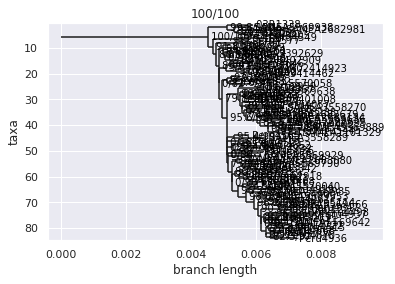

                                        _____ 03R1338
                                    ___|
                                   |   |  ___ SAMEA5569938
                                   |   |_|
                                   |     | _________ SAMEA2682981
                                   |     ||
                                   |      |, Peru3056
                                   |      ||
___________________________________|       |___ Peru3405
                                   |
                                   |      ______ Peru4549
                                   | ____|
                                   ||    |__ Peru4577
                                   ||
                                   || _______ 1791
                                   |||
                                   ||| _ 01R0272
                                    |||
                                    |,|___ 02R0099
                                    |||
                                    |

In [161]:
est_TMRCA_for_isolates(isolate_tags_in_phylogeny_with_both_indels)

### Does the mmpL5 deletion always occur with the mmpR insertion?

In [162]:
isolates_with_both_indels = [(mmpR_ins and mmpL5_del) for mmpR_ins , mmpL5_del in zip(list(genotypes_for_mmpR_ins == 1) , list(genotypes_for_mmpL5_del == 1))]

In [163]:
sum(isolates_with_both_indels)

82

In [164]:
INDEL_isolate_annotation_DF[isolates_with_both_indels]

,isolate_ID,lineage_call
38,99R893,4.11
449,Peru4670,4.11
645,SAMEA5569914,4.11
708,Peru5003,4.11
1224,Peru3367,4.11
1500,SAMEA5569985,4.11
1531,SAMEA5569929,4.11
1886,Peru4683,4.11
3018,00R1547,4.11
3493,Peru4919,4.11


In [165]:
set(INDEL_isolate_annotation_DF[isolates_with_both_indels].lineage_call)

{'4.11'}

#### Isolates that had the mmpR insertion but *not* the mmpL5 deletion.

In [166]:
isolates_with_only_mmpR_ins = [(mmpR_ins and not mmpL5_del) for mmpR_ins , mmpL5_del in zip(list(genotypes_for_mmpR_ins == 1) , list(genotypes_for_mmpL5_del == 1))]

In [167]:
sum(isolates_with_only_mmpR_ins)

4

In [168]:
INDEL_isolate_annotation_DF[isolates_with_only_mmpR_ins]

,isolate_ID,lineage_call
4698,03R1338,4.11
18334,SAMEA5562524,2.2.1.1.1
22200,SAMN02350468,2.2.1.1.1
25956,SAMEA5562525,2.2.1.1.1


#### Isolates that had the mmpL5 deletion but *not* the mmpR insertion.

In [169]:
isolates_with_only_mmpL5_del = [(not mmpR_ins and mmpL5_del) for mmpR_ins , mmpL5_del in zip(list(genotypes_for_mmpR_ins == 1) , list(genotypes_for_mmpL5_del == 1))]

In [170]:
sum(isolates_with_only_mmpL5_del)

1

In [172]:
INDEL_isolate_annotation_DF[isolates_with_only_mmpL5_del]

,isolate_ID,lineage_call
14567,Peru4498,4.11


#### Which isolates had the mmpR deletion?

In [173]:
INDEL_isolate_annotation_DF[genotypes_for_mmpR_del == 1]

,isolate_ID,lineage_call
1330,SAMEA4473389,4.3.i4.2
1378,SAMEA4473391,4.3.i4.2
4531,SAMN02586061,4.3.i3.1
9401,SAMEA3558441,4.3.i4.2
11029,SAMEA3558748,4.3.i4.2
11546,SAMEA3558418,4.3.i4.2
14172,SAMEA4473390,4.3.i4.2
14661,SAMEA3558759,4.3.i4.2
18439,SAMEA4473414,4.3.i4.2
18817,SAMEA4473396,4.3.i4.2


In [174]:
from collections import Counter
Counter(INDEL_isolate_annotation_DF[genotypes_for_mmpR_del == 1].lineage_call)

Counter({'2.2.1.1.1': 4, '3.1.1': 1, '4.3.i3.1': 1, '4.3.i4.2': 14})

# [6] Get MICs for isolates that have them in phylogeny

Load the MIC data

In [175]:
MIC_data = pd.read_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/MIC data/Isolate_accession-numbers_LIN_CLO.xlsx').set_index('ID')

In [176]:
MIC_data.head()

,BioProject,Run No,BioSample,WGSAccessionNumber/Run Accession,Alt ID,CLO,LIN
ID,,,,,,,
00-R0223,PRJEB26000,NaN,ERS2401270,ERR2516592,00-R0223,NaN,NaN
00-R0312,PRJEB26000,NaN,ERS2401327,ERR2516649,00-R0312,NaN,NaN
00-R0435,PRJEB26000,NaN,ERS2401310,ERR2516632,00-R0435,NaN,NaN
00-R0453,PRJEB26000,NaN,ERS2401368,ERR2516690,00-R0453,NaN,NaN
00-R1566,PRJEB26000,NaN,ERS2401251,ERR2516573,00-R1566,NaN,NaN


Subset to isolate IDs in the phylogeny

In [177]:
np.shape(MIC_data)

(1483, 7)

In [178]:
isolate_tags_in_phylogeny_with_MIC_bool = [(isolate_ID in isolate_tags_in_phylogeny) for isolate_ID in MIC_data.index]

In [179]:
MIC_data = MIC_data[isolate_tags_in_phylogeny_with_MIC_bool]

In [180]:
np.shape(MIC_data)

(84, 7)

In [181]:
MIC_data.head(n=40)

,BioProject,Run No,BioSample,WGSAccessionNumber/Run Accession,Alt ID,CLO,LIN
ID,,,,,,,
Peru2918,PRJNA343736,Run64,SAMN06010136,MQAX00000000,M0016660-4,NaN,<=0.25
Peru2959,PRJNA343736,Run64,SAMN06010172,MQCG00000000,M0000477-1,NaN,0.25-0.5
Peru2965,PRJNA343736,Run64,SAMN06010178,MQCM00000000,M0000538-0,NaN,<=0.25
Peru3006,PRJNA343736,Run64,SAMN06010200,MQDI00000000,M0014337-1,NaN,<=0.25
Peru3031,PRJNA343736,Run64,SAMN06010224,MQEG00000000,M0004756-4,NaN,0.25-0.5
Peru3056,PRJNA343736,Run64,SAMN06010243,MQEZ00000000,M0003646-8,NaN,0.25-0.5
Peru3060,PRJNA343736,Run64,SAMN06010247,MQFD00000000,M0021409-9,NaN,<=0.25
Peru3262,PRJNA343736,Run67,SAMN06010408,MQLV00000000,M0014907-1,NaN,<=0.25
Peru3332,PRJNA343736,Run67,SAMN06010469,MQJS00000000,M0023187-9,NaN,<=0.25


In [182]:
MIC_data.tail(n=45)

,BioProject,Run No,BioSample,WGSAccessionNumber/Run Accession,Alt ID,CLO,LIN
ID,,,,,,,
Peru4547,PRJNA343736,Run79,SAMN05918647,MMTI00000000,03-R0060,NaN,<=0.25
Peru4549,PRJNA343736,Run79,SAMN05918649,MMTG00000000,02-R1930,NaN,<=0.25
Peru4553,PRJNA343736,Run79,SAMN05918653,MMTC00000000,02-R1663,NaN,<=0.25
Peru4565,PRJNA343736,Run79,SAMN05918665,MMSQ00000000,03-R0267,NaN,0.5-1.0
Peru4577,PRJNA343736,Run79,SAMN05918677,MMSE00000000,02-R1595,NaN,0.5-1.0
Peru4582,PRJNA343736,Run79,SAMN05918682,MMRZ00000000,03-R0465,NaN,<=0.25
Peru4589,PRJNA343736,Run79,SAMN05918689,MMRS00000000,03-R0744,NaN,NaN
Peru4646,PRJNA343736,Run79,SAMN05918736,MMPY00000000,01-R1134,NaN,0.5-1.0
Peru4647,PRJNA343736,Run79,SAMN05918737,MMPX00000000,98-R394,NaN,<=0.25
